# Correlations in electricity production in the EU

We'll need pandas for the data, matplotlib for the plotting, and seaborn because it's pretty.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")
idx = pd.IndexSlice

Importing the production data for the EU, 2019.

In [2]:
prod_data = pd.read_csv('Partage.csv',
                   header=[0,1,2,3],
                   index_col=0,
                   delimiter=';',
                   decimal=',')

First try to see if we see any load factor correlation for France and Germany.

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text major ticklabel objects>)

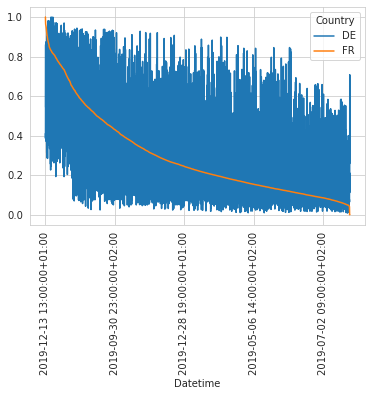

In [3]:
wind = prod_data.loc[:,
             idx[:,
                 ['DE','FR'],
                 ['Wind Onshore', 'Wind Offshore'],
                 :]
            ]

wind_agg = wind.groupby(level=1, axis=1).sum()

wind_agg_scale = wind_agg/wind_agg.max(axis=0)

r = wind_agg_scale[['DE','FR']].sort_values(by='FR', ascending=False).plot()
plt.xticks(rotation=90)

It's a mess so let's make a heatmap (kdeplot) instead.

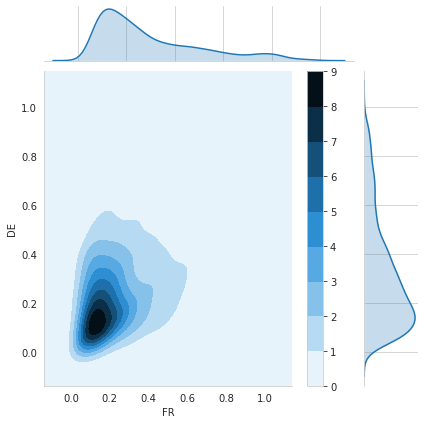

In [4]:
sns.jointplot(data=wind_agg_scale,
              x='FR',
              y='DE',
              kind='kde',
              cbar=True,)

Let's write a function to make this automatic. Plot a grid when more than two countries are in the list.

In [5]:
def correlation_plot(country_list, techno_list, data=prod_data, cmap='coolwarm', filter_zeros=True):
    
    data = prod_data.loc[:,
                 idx[:,
                     country_list,
                     techno_list,
                     :]
                ]
    
    data_agg = data.groupby(level=1, axis=1).sum()
    
    if filter_zeros:
        data_agg = data_agg[data_agg.sum(1) > 0]
    
    data_agg_scale = data_agg/data_agg.max(axis=0)
    
    if len(country_list) == 2:
        
        ax_lim = ((0,data_agg[country_list[0]].max()),(0,data_agg[country_list[1]].max()))
        
        color = plt.cm.get_cmap(cmap)
        
        p = sns.jointplot(data=data_agg,
                  x=country_list[0],
                  y=country_list[1],
                  kind='kde',
                  n_levels=20,
                  joint_kws={'clip':ax_lim,
                             'cmap':cmap},
                  marginal_kws={'color':color(color.N)},
                  shade_lowest=False
                         )
                
        p.ax_joint.set_xlim(ax_lim[0])
        p.ax_joint.set_ylim(ax_lim[1])

        p.fig.set_size_inches((10,10))
        
        p.annotate(stats.pearsonr)
        
    else:
        
        p = sns.PairGrid(data_agg)
        p.map_upper(sns.scatterplot, alpha=0.2, s=3, edgecolor='none')
        p.map_lower(sns.kdeplot, shade=True, shade_lowest=False)
        p.map_diag(sns.kdeplot, lw=3)
        plt.subplots_adjust(top=0.9)
    
    return p

/home/thomas.gibon/.conda/envs/best/lib/python3.6/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(3150.0, 40000, 'FR$\\rightarrow$DE capacity')

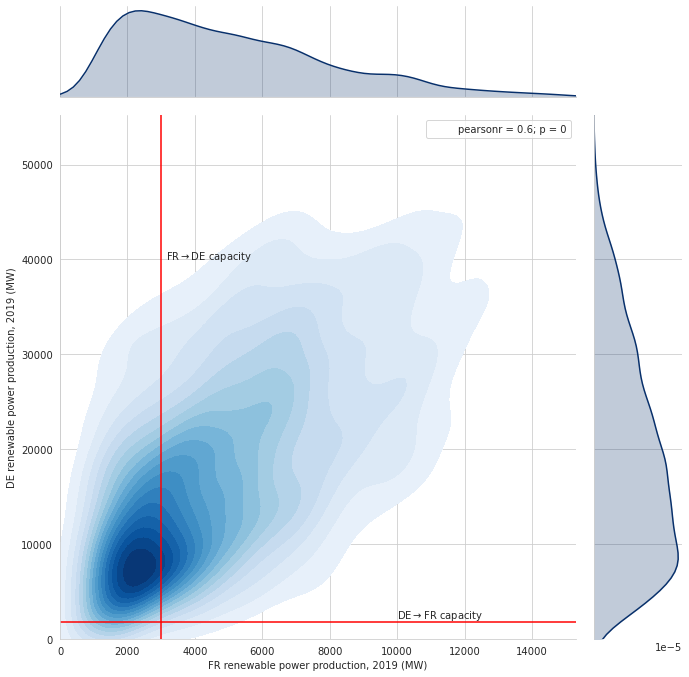

In [6]:
p = correlation_plot(['FR','DE'], ['Wind Onshore', 'Wind Offshore', 'Solar'], cmap='Blues')

p.set_axis_labels('FR renewable power production, 2019 (MW)', 'DE renewable power production, 2019 (MW)')

p.ax_joint.axhline(y=1800, color='r')
p.ax_joint.text(x=10000,y=1800*1.2,s=r'DE$\rightarrow$FR capacity')

p.ax_joint.axvline(x=3000, color='r')
p.ax_joint.text(x=3000*1.05,y=40000,s=r'FR$\rightarrow$DE capacity')

/home/thomas.gibon/.conda/envs/best/lib/python3.6/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


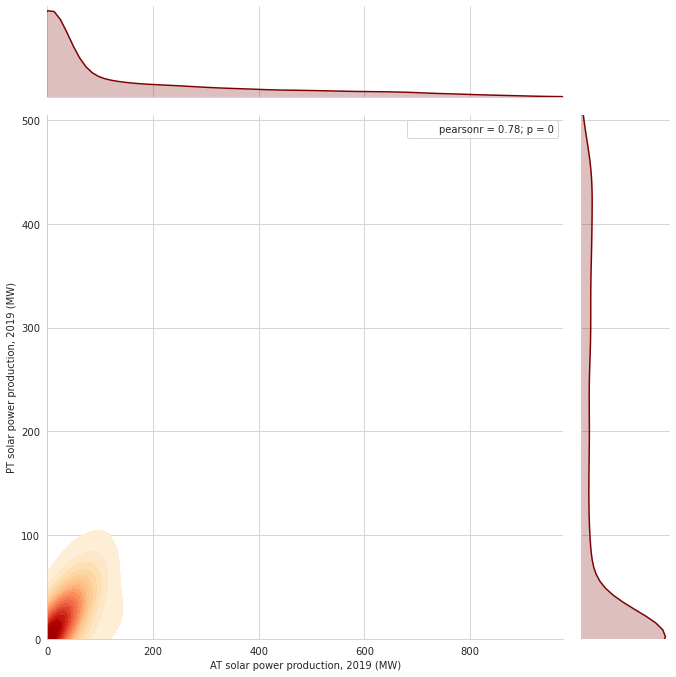

In [7]:
country_list = ['AT','PT']

p = correlation_plot(country_list, ['Solar'], cmap='OrRd', filter_zeros=False)

p.set_axis_labels('{} solar power production, 2019 (MW)'.format(country_list[0]), '{} solar power production, 2019 (MW)'.format(country_list[1]))


Text(0.5, 0.98, "Wind power production in the top 5 EU producing countries, 2019 (MW)\nCan neighbours supply us when the wind doesn't blow at home?")

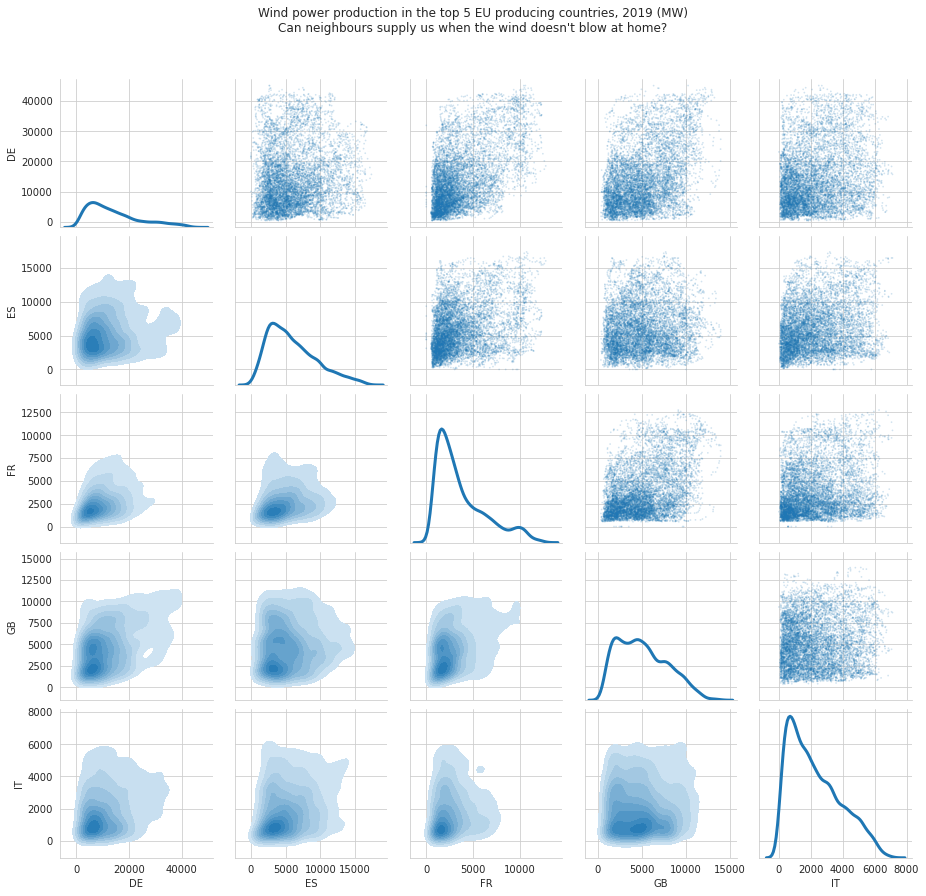

In [9]:
g = correlation_plot(['DE','ES','GB','FR','IT'],
                     ['Wind Onshore', 'Wind Offshore'],
                     data=prod_data,
                     cmap='Blues',
                     filter_zeros=True)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Wind power production in the top 5 EU producing countries, 2019 (MW)\nCan neighbours supply us when the wind doesn\'t blow at home?')